In [27]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet/" ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

<ipython-input-28-255f4ac980e9>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [29]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    #cmax = np.clip(c * 1.2, 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

slack_blue  = get_alpha_cmap((63, 81, 181))
slack_green = get_alpha_cmap((76, 175, 80) )
slack_red   = get_alpha_cmap((210, 40, 95))

slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

brown = get_alpha_cmap((121, 85, 72))
dark_brown = get_alpha_cmap((109, 76, 65))

In [37]:
baseline_to_color = {
'zero' : anthracite,
'uniform' : slack_violet,
'normal' : slack_violet,
'permutation' : google_green,
'local_permutation' : google_green,
'local_mean' : google_blue,
'mean' : google_blue,
'median' : google_blue,
'random_color' : anthracite,
'scramble_phase' : slack_red,
'scramble_amplitude' : slack_red,
'fv': slack_yellow,
}

baseline_to_linestyle = {
'zero' : 'o',
'uniform' : 'o',
'normal' : 'x',
'permutation' : 'o',
'local_permutation' : 'x',
'local_mean' : 'o',
'mean' : 'x',
'median' : 's',
'random_color' : 'x',
'scramble_phase' : 'o',
'scramble_amplitude' : 'x',
'fv': '*'
}

In [31]:
data_removal = np.load('/content/results_resnet/removal_scores_resnet.npy', allow_pickle=True)[()]
data_removal2 = np.load('/content/results_resnet/removal_scores_resnet_fv.npy', allow_pickle=True)[()]
data_ood = np.load('/content/results_resnet/ood_scores_resnet.npy', allow_pickle=True)[()]
data_ood2 = np.load('/content/results_resnet/ood_scores_resnet_fv.npy', allow_pickle=True)[()]

data_ood.update(data_ood2)
data_removal.update(data_removal2)

data_ood.keys()

dict_keys(['zero', 'uniform', 'normal', 'permutation', 'local_mean', 'local_permutation', 'mean', 'median', 'random_color', 'scramble_phase', 'scramble_amplitude', 'fv'])

In [32]:
results = {}

for baseline in data_ood.keys():

  removal_curve = [s/1000/1000 for _,s in data_removal[baseline]]
  removal_score = np.mean(removal_curve)

  ood_curve = [np.mean(s[1]) for s in data_ood[baseline]]
  ood_score = np.mean(ood_curve)

  results[baseline] = [ood_score, removal_score]

In [49]:
import sklearn
from sklearn import linear_model

p = [results[v] for v in data_ood.keys() if v != 'fv']
p = np.array(p)
print(p.shape)
m = linear_model.LinearRegression()
m.fit(p[:, 0][:, None], p[:, 1])
a, b = m.coef_, m.intercept_

reg_x = np.linspace(p[:, 0].min(), p[:, 0].max(), 100)
reg_y = reg_x * a + b

(11, 2)


zero 33.212402 0.23901480937500003
uniform 34.48389 0.23817420390625
normal 34.822052 0.23821885000000004
permutation 33.598225 0.23865335000000001
local_mean 30.017529 0.24022013203124998
local_permutation 31.289318 0.24072301249999994
mean 32.06695 0.23917384687500004
median 31.750721 0.23920075624999998
random_color 33.70404 0.23916216953125008
scramble_phase 33.282143 0.23861341093750005
scramble_amplitude 34.18668 0.23865278203125
fv 31.730011 0.23863279218750005


<ipython-input-52-a5960c7b95bc>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ood, removal, label=baseline.replace('_', ' '), s=si, c=color(1.0),


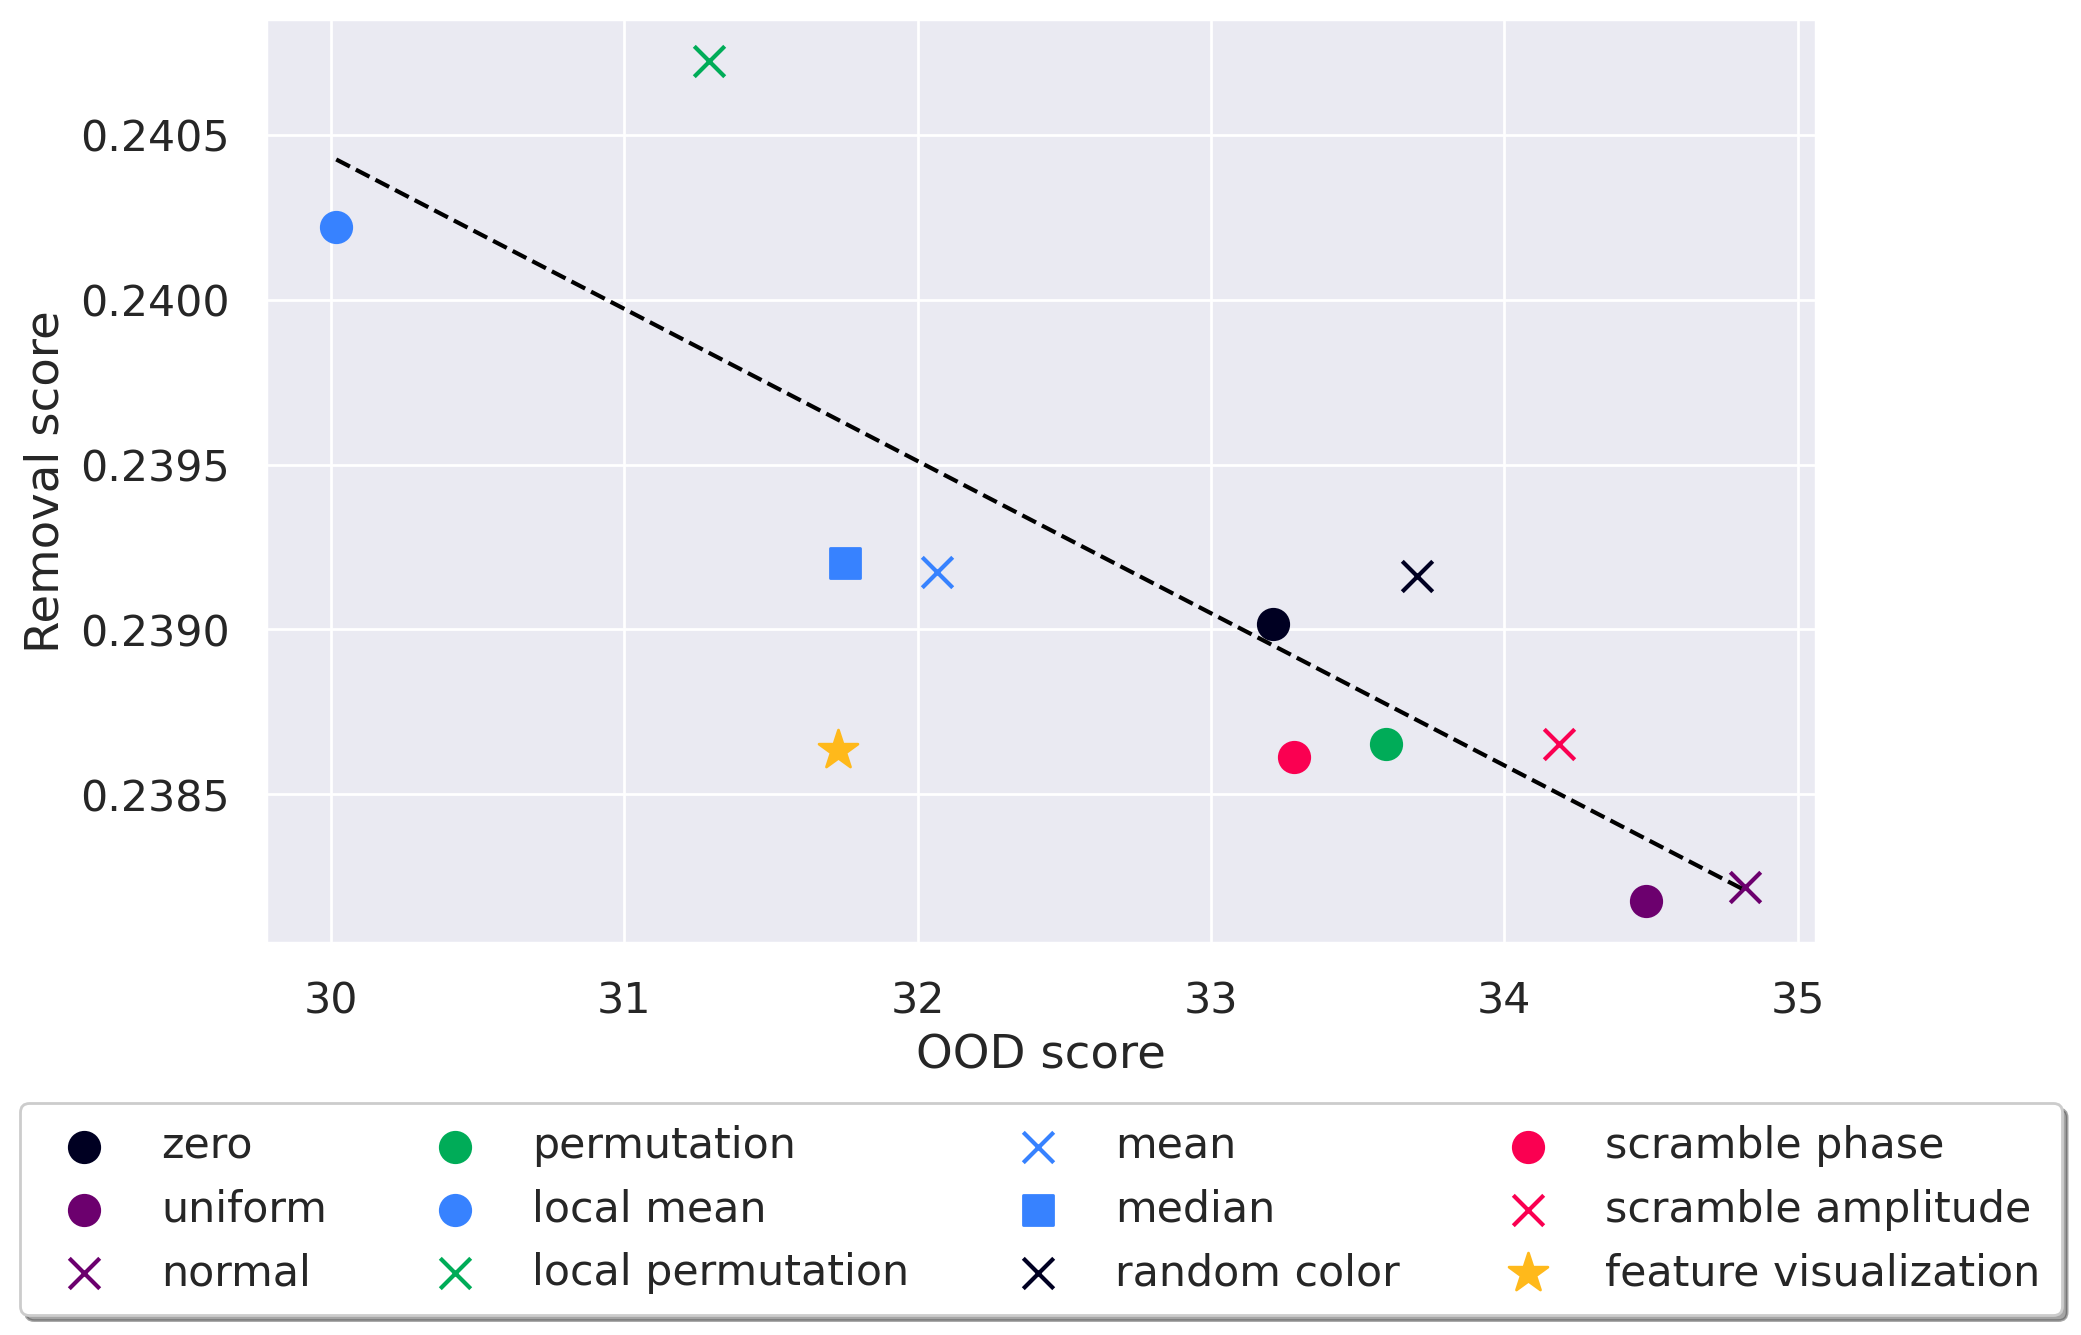

In [52]:
sns.set(font_scale=1.4)
set_size(10, 6)
cmap = plt.get_cmap('viridis')

s = 120

plt.plot(reg_x, reg_y, linestyle="--", color="black")

for baseline in results:
  ood, removal = results[baseline]

  color = baseline_to_color[baseline]
  ps = baseline_to_linestyle[baseline]

  print(baseline, ood, removal)

  si = s if baseline != 'fv' else s * 1.8
  if baseline == 'fv':
    baseline = 'feature visualization'
  plt.scatter(ood, removal, label=baseline.replace('_', ' '), s=si, c=color(1.0),
              alpha=1.0, marker=ps)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')
#plt.xticks([0, xs[len(xs)//2], xs[-1]], [0, 50, 100])
plt.xlabel("OOD score")
plt.ylabel('Removal score')
plt.savefig('removal_resnet.png', dpi=400, transparent=True)
#plt.title()

In [53]:
results = {}

for baseline in data_ood.keys():

  removal_curve = [s/1000/1000 for _,s in data_removal[baseline]]
  ood_curve = [np.mean(s[1]) for s in data_ood[baseline]]

  results[baseline] = [ood_curve, removal_curve]

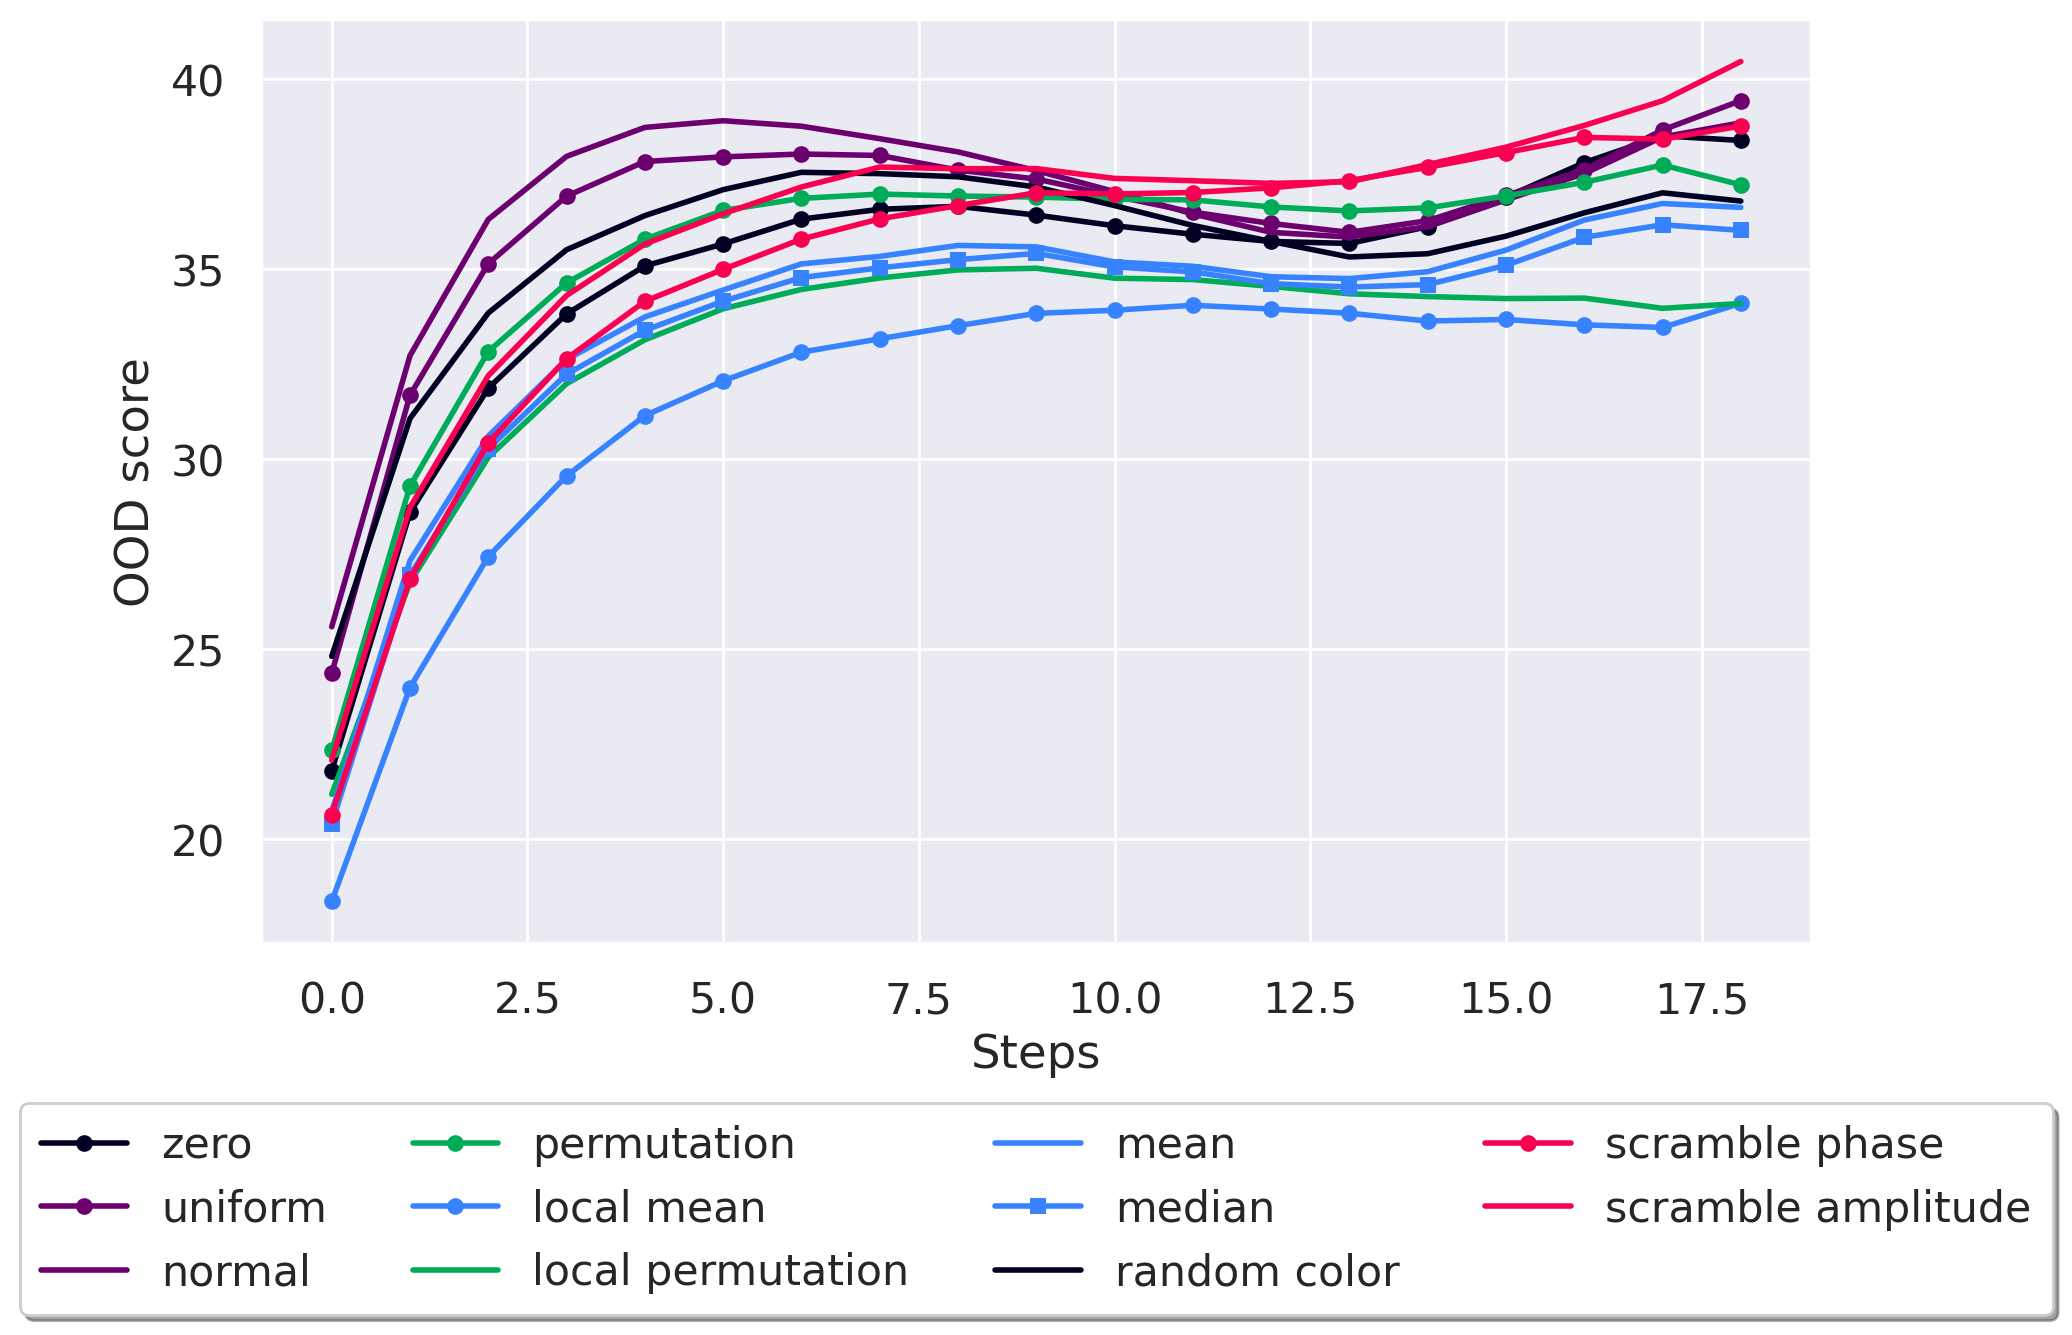

In [57]:
sns.set(font_scale=1.4)
set_size(10, 6)
cmap = plt.get_cmap('viridis')
lw = 2

for baseline in results:
  if baseline == 'fv':
    continue
  ood, removal = results[baseline]
  ood = ood[1:]

  color = baseline_to_color[baseline]
  ps = baseline_to_linestyle[baseline]

  plt.plot(ood, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0),
              alpha=1.0, marker=ps)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')
#plt.xticks([0, xs[len(xs)//2], xs[-1]], [0, 50, 100])
plt.xlabel("Steps")
plt.ylabel('OOD score')
plt.savefig('ood_curves.png', dpi=400, transparent=True)
#plt.title()

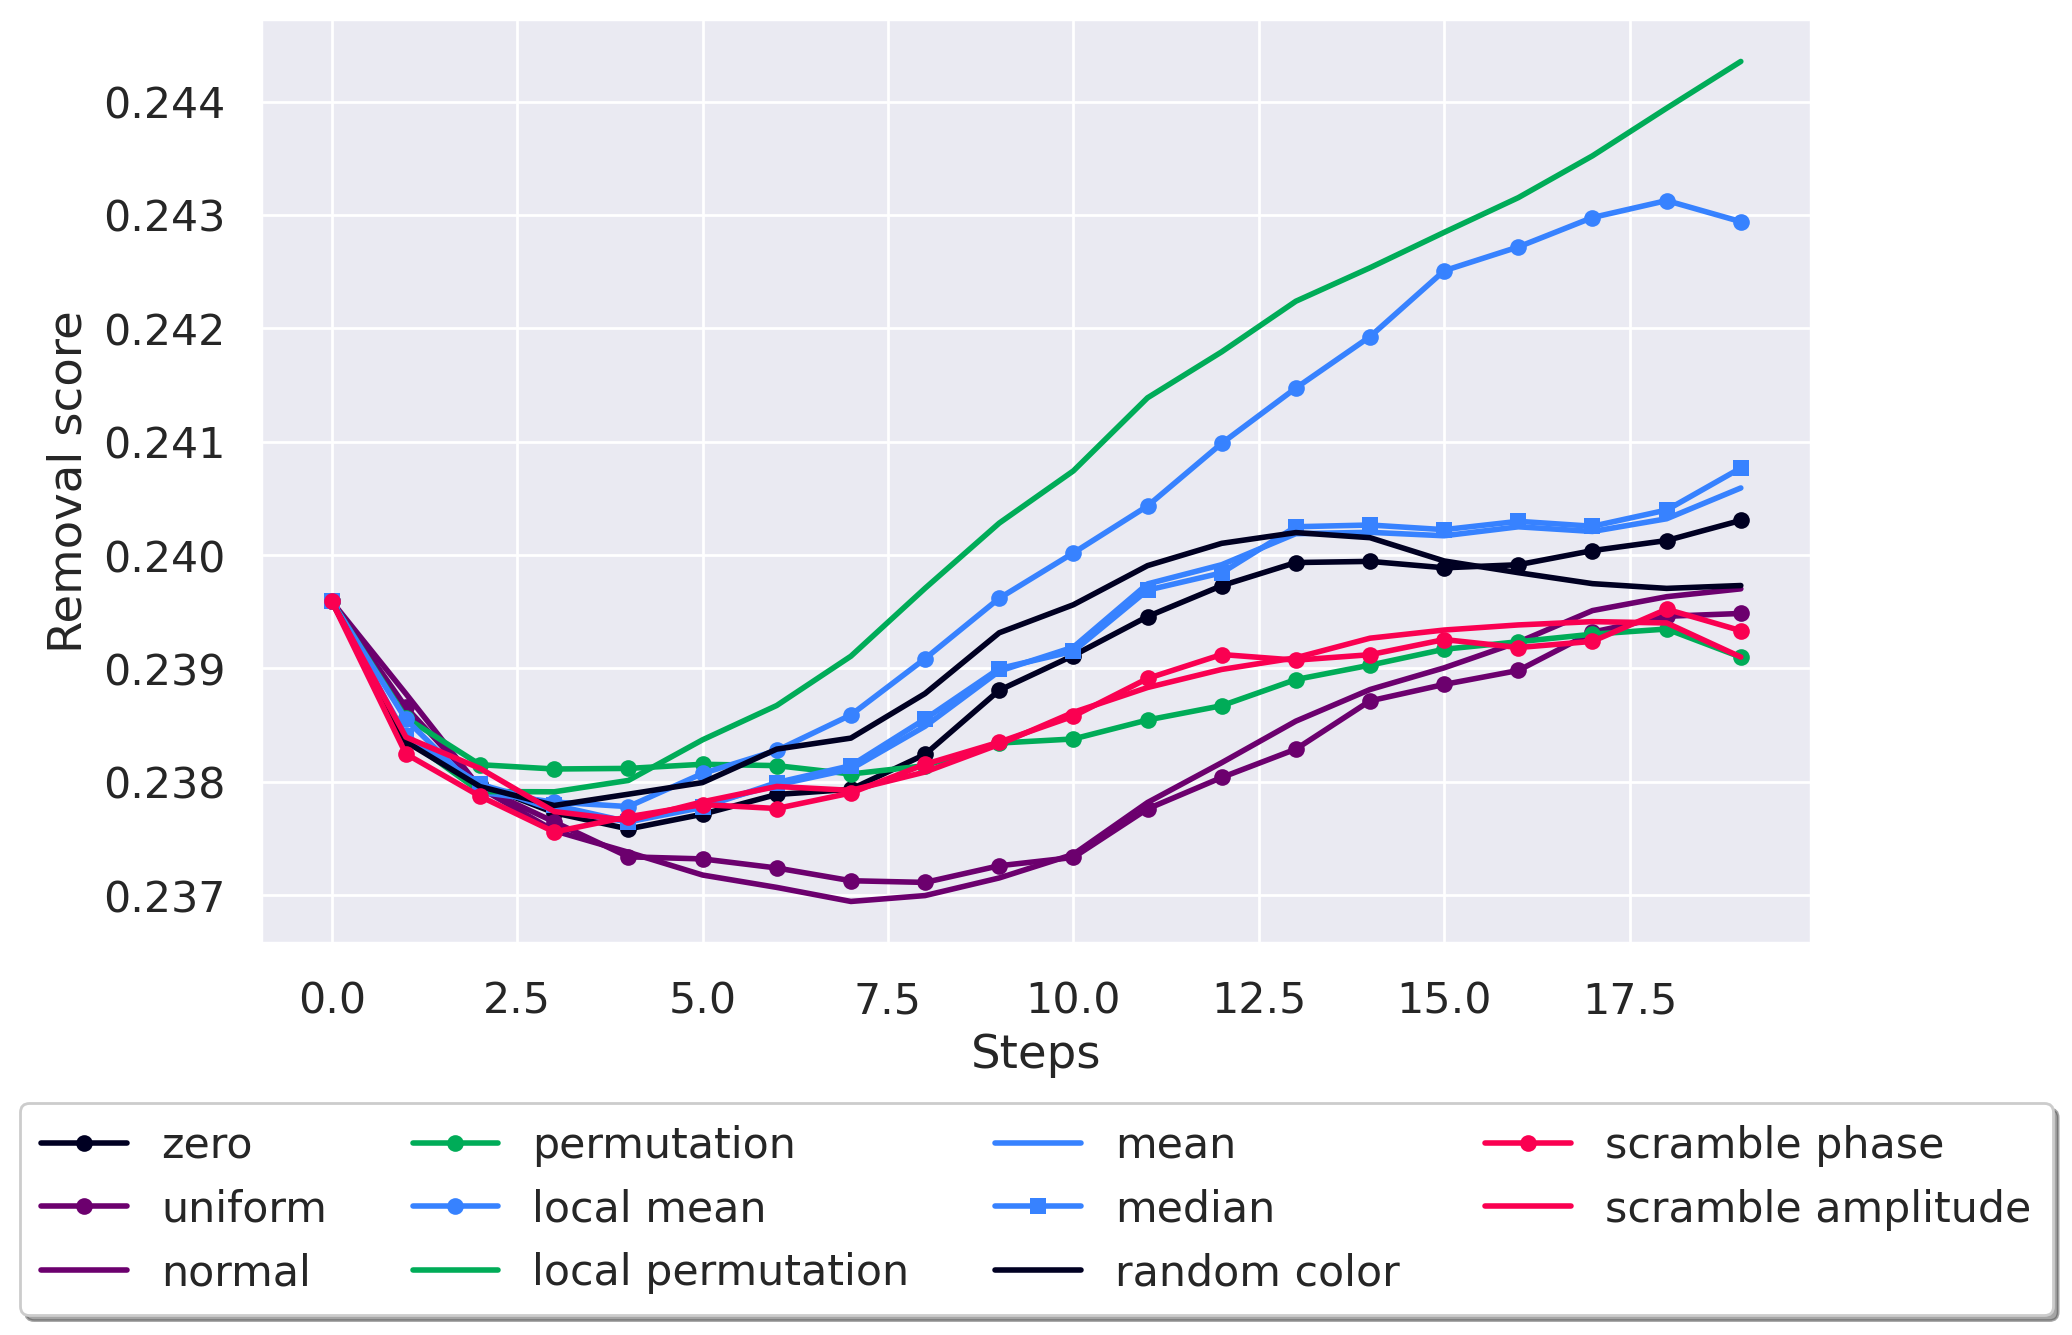

In [59]:
sns.set(font_scale=1.4)
set_size(10, 6)
cmap = plt.get_cmap('viridis')
lw = 2

for baseline in results:
  if baseline == 'fv':
    continue
  ood, removal = results[baseline]
  removal = removal[:]

  color = baseline_to_color[baseline]
  ps = baseline_to_linestyle[baseline]

  plt.plot(removal, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0),
              alpha=1.0, marker=ps)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')
#plt.xticks([0, xs[len(xs)//2], xs[-1]], [0, 50, 100])
plt.xlabel("Steps")
plt.ylabel('Removal score')
plt.savefig('removal_curves.png', dpi=400, transparent=True)
#plt.title()

In [ ]:
sns.set(font_scale=0.7)
set_size(5, 3)

for i in range(30):

  #c1, c2, c3, c4 = np.random.choice([slack_blue, slack_green, slack_red, slack_yellow, slack_violet, google_blue, google_red, google_yellow, google_green, deep_purple, pink, brown], 4, replace=False)
  c3, c4 = np.random.choice([slack_blue, slack_green, slack_red, google_blue, google_red, google_green, deep_purple, pink, brown], 2, replace=False)
  c1 = slack_violet
  c2 = google_yellow

  baseline_to_color = {
  'zero' : anthracite,
  'uniform' : c1,
  'normal' : c1,
  'permutation' : c2,
  'local_permutation' : c2,
  'local_mean' : c3,
  'mean' : c3,
  'median' : c3,
  'random_color' : anthracite,
  'scramble_phase' : c4,
  'scramble_amplitude' : c4,
  }


  for baseline in results:
    points = results[baseline]

    curve = [np.mean(p) for p in points][1:]
    stds = [np.std(p) for p in points][1:]

    color = baseline_to_color[baseline]
    ls = baseline_to_linestyle[baseline]

    xs, ys = poly_interp(curve)

    #plt.plot(curve, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)
    plt.plot(xs, ys, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)

  legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25),
                        fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                        facecolor='white')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
set_size(15, 8)

for baseline_name, baseline_func in baselines.items():
  scores = [np.mean(d) for _, d in RESULTS[baseline_name]]
  plt.plot(scores, label=baseline_name)

plt.tight_layout()
plt.legend()

In [ ]:
import os

results = {}

for p in os.listdir("/content/results_resnet"):
  if "ood_" not in p:
    data = np.load('/content/results_resnet/'+p, allow_pickle=True)[()]
    data = [(m, d, i, u) for m, d, i, u in data if 'Guided' not in m]
    deletions = [(m.replace('resnet50_', '').replace('.npy', ''), d) for m, d, i, _ in data]
    insertions = [(m.replace('resnet50_', '').replace('.npy', ''), i) for m, d, i, _ in data]
    methods = [m.replace('resnet50_', '').replace('.npy', '') for m, d, i, _ in data]
    results[p.replace('.npy', '')] = (deletions, insertions)

baselines = list(results.keys())

In [ ]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id, baselines

({0: 'GuidedBackprop',
  1: 'Occlusion',
  2: 'SobolAttributionMethod',
  3: 'Saliency',
  4: 'IntegratedGradients',
  5: 'VarGrad',
  6: 'SmoothGrad',
  7: 'SquareGrad',
  8: 'GradCAMPP',
  9: 'DeconvNet',
  10: 'GradCAM',
  11: 'GradientInput',
  12: 'Rise',
  13: 'HsicAttributionMethod'},
 ['local_permutation',
  'random_color',
  'local_mean',
  'normal',
  'scramble_amplitude',
  'uniform',
  'scramble_phase',
  'median',
  'zero',
  'mean',
  'permutation'])

In [ ]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id = {m : i for m, i in enumerate(methods)}

ranks_del = {m: {} for m in methods}
ranks_ins = {m: {} for m in methods}

for baseline in results.keys():
  deletions, insertions = results[baseline]

  order_del = np.argsort([float(d) for m, d in deletions])
  order_ins = np.argsort([float(i) for m, i in insertions])[::-1]

  for rank_i, i in enumerate(order_del):
    ranks_del[deletions[i][0]][baseline] = rank_i

  for rank_i, i in enumerate(order_ins):
    ranks_ins[insertions[i][0]][baseline] = rank_i

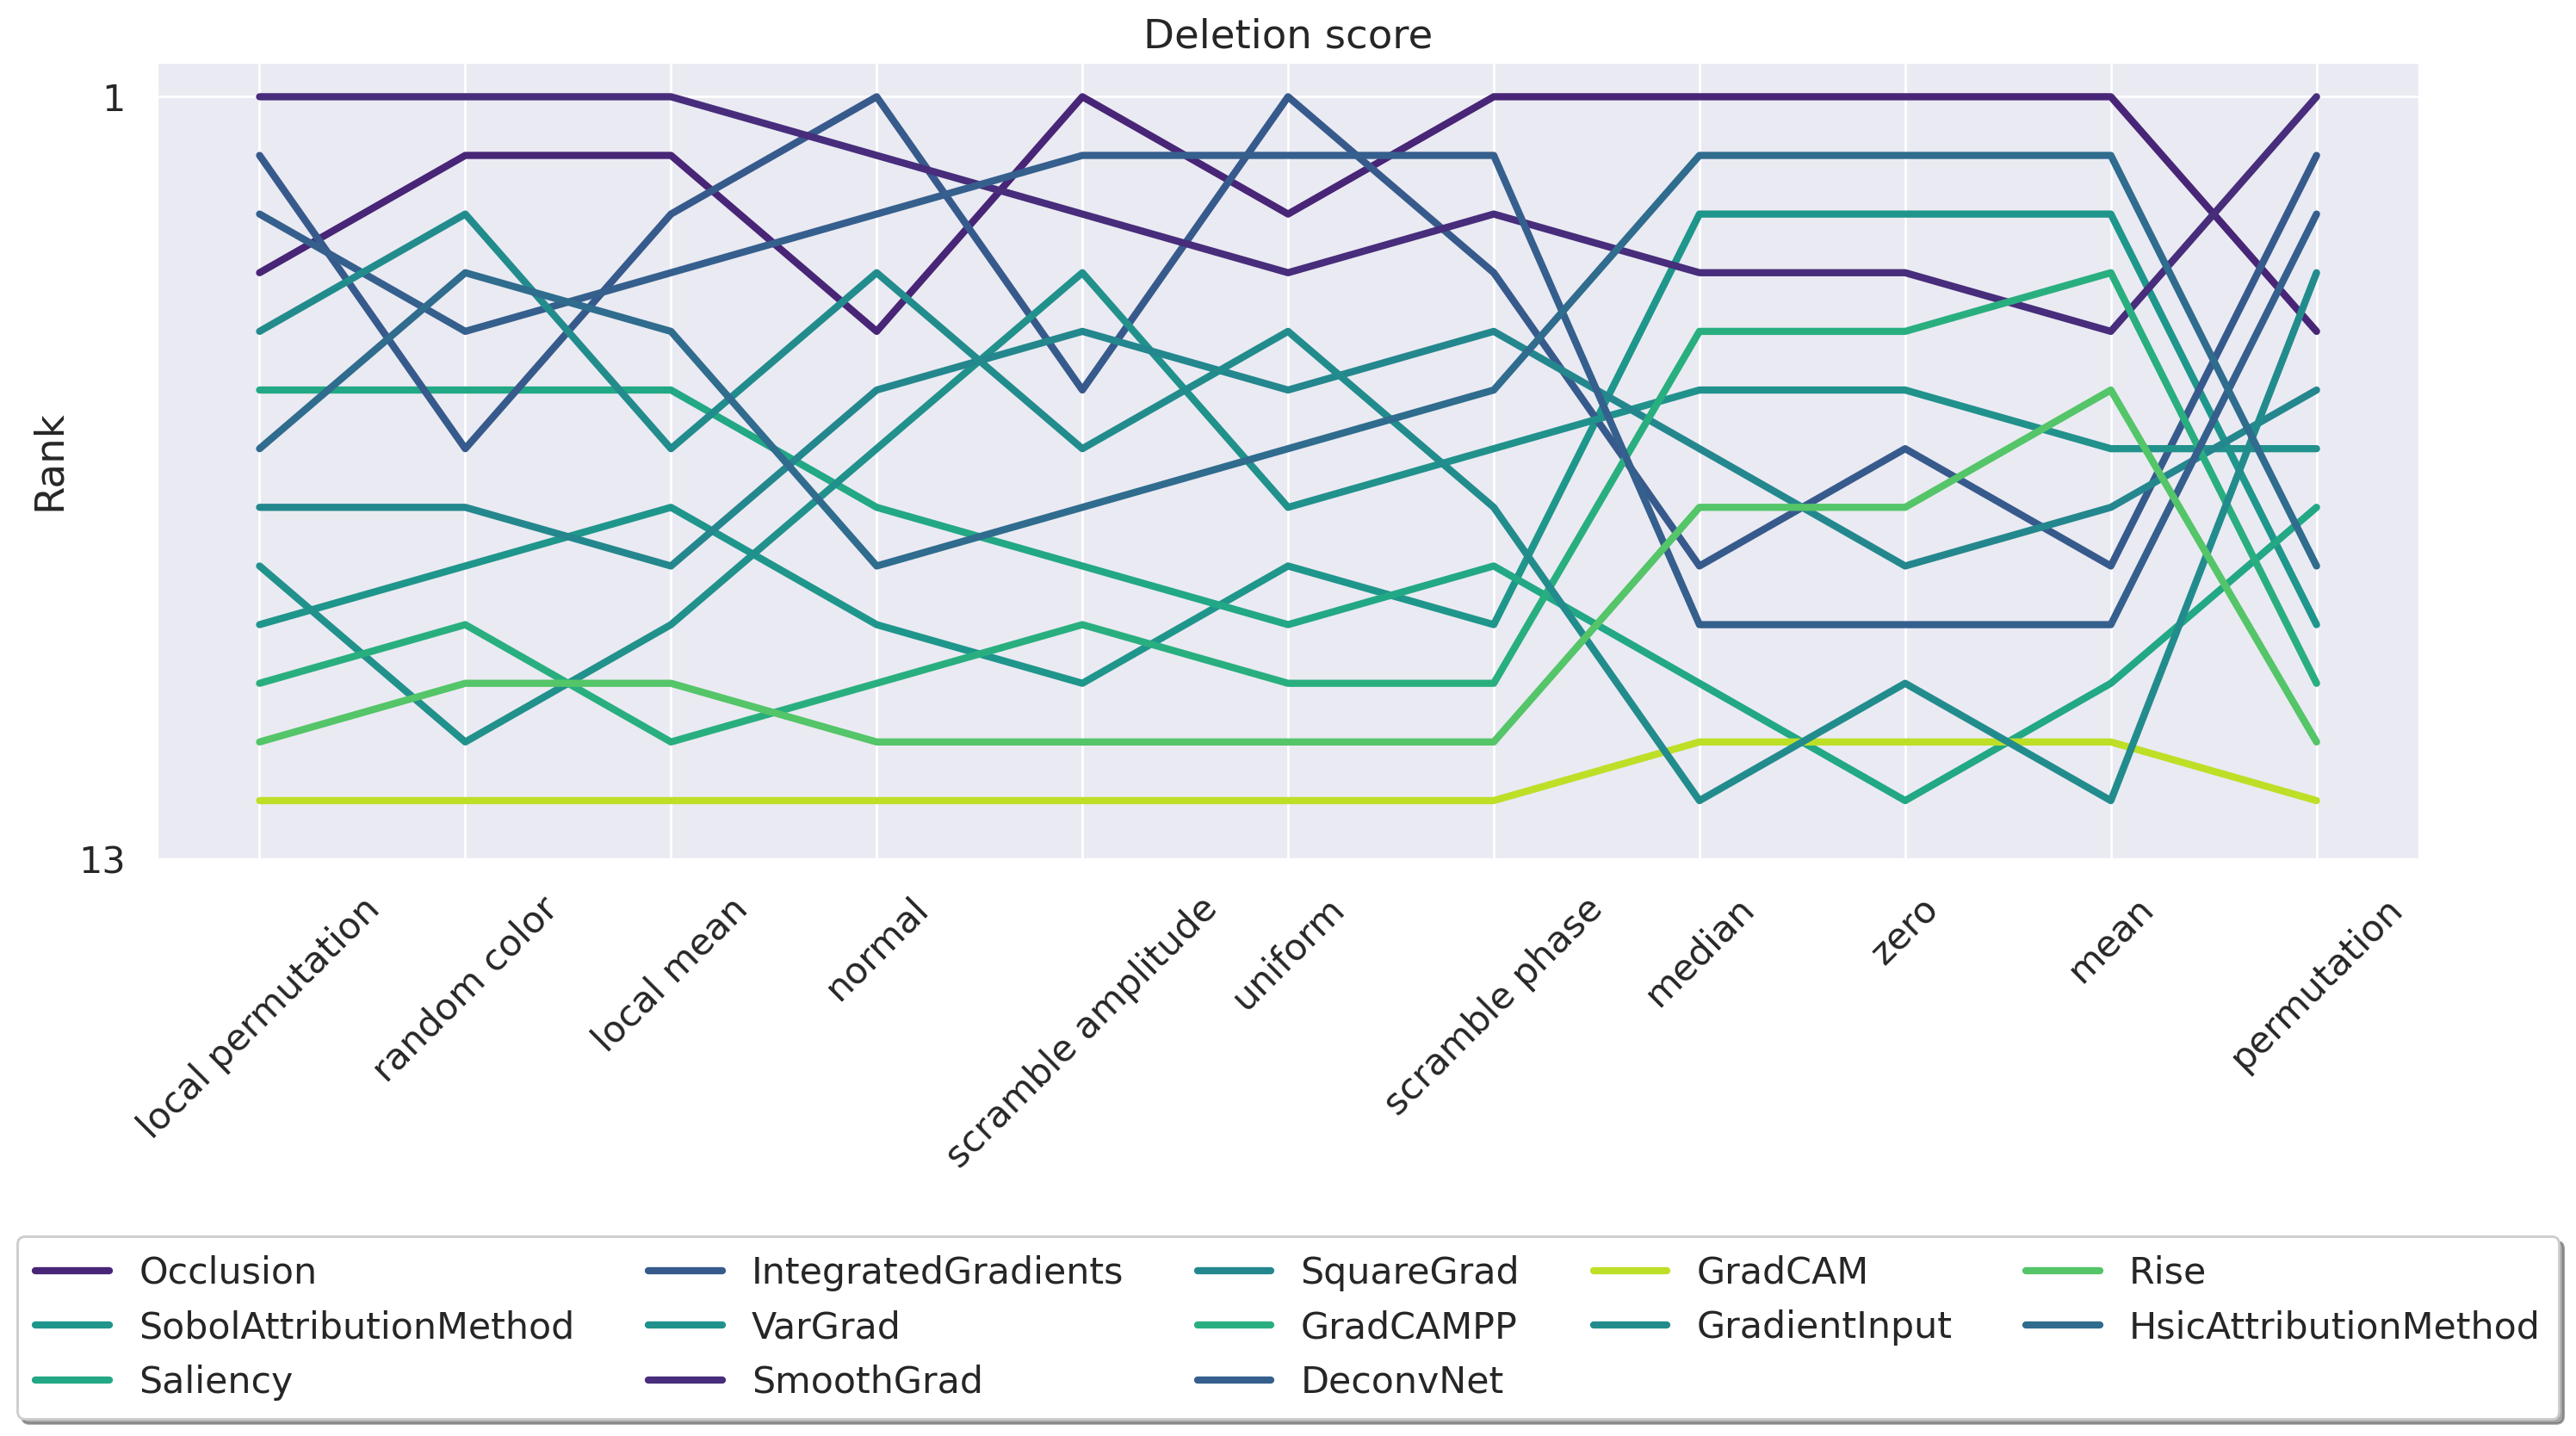

In [ ]:
sns.set(font_scale=1.4)
set_size(16, 10)
cmap = plt.get_cmap('viridis')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_del[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=5, frameon=True,
                      facecolor='white') # = ivan

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Deletion score")
plt.tight_layout()
plt.savefig('deletion_ranking.png', dpi=400, transparent=True)
plt.show()

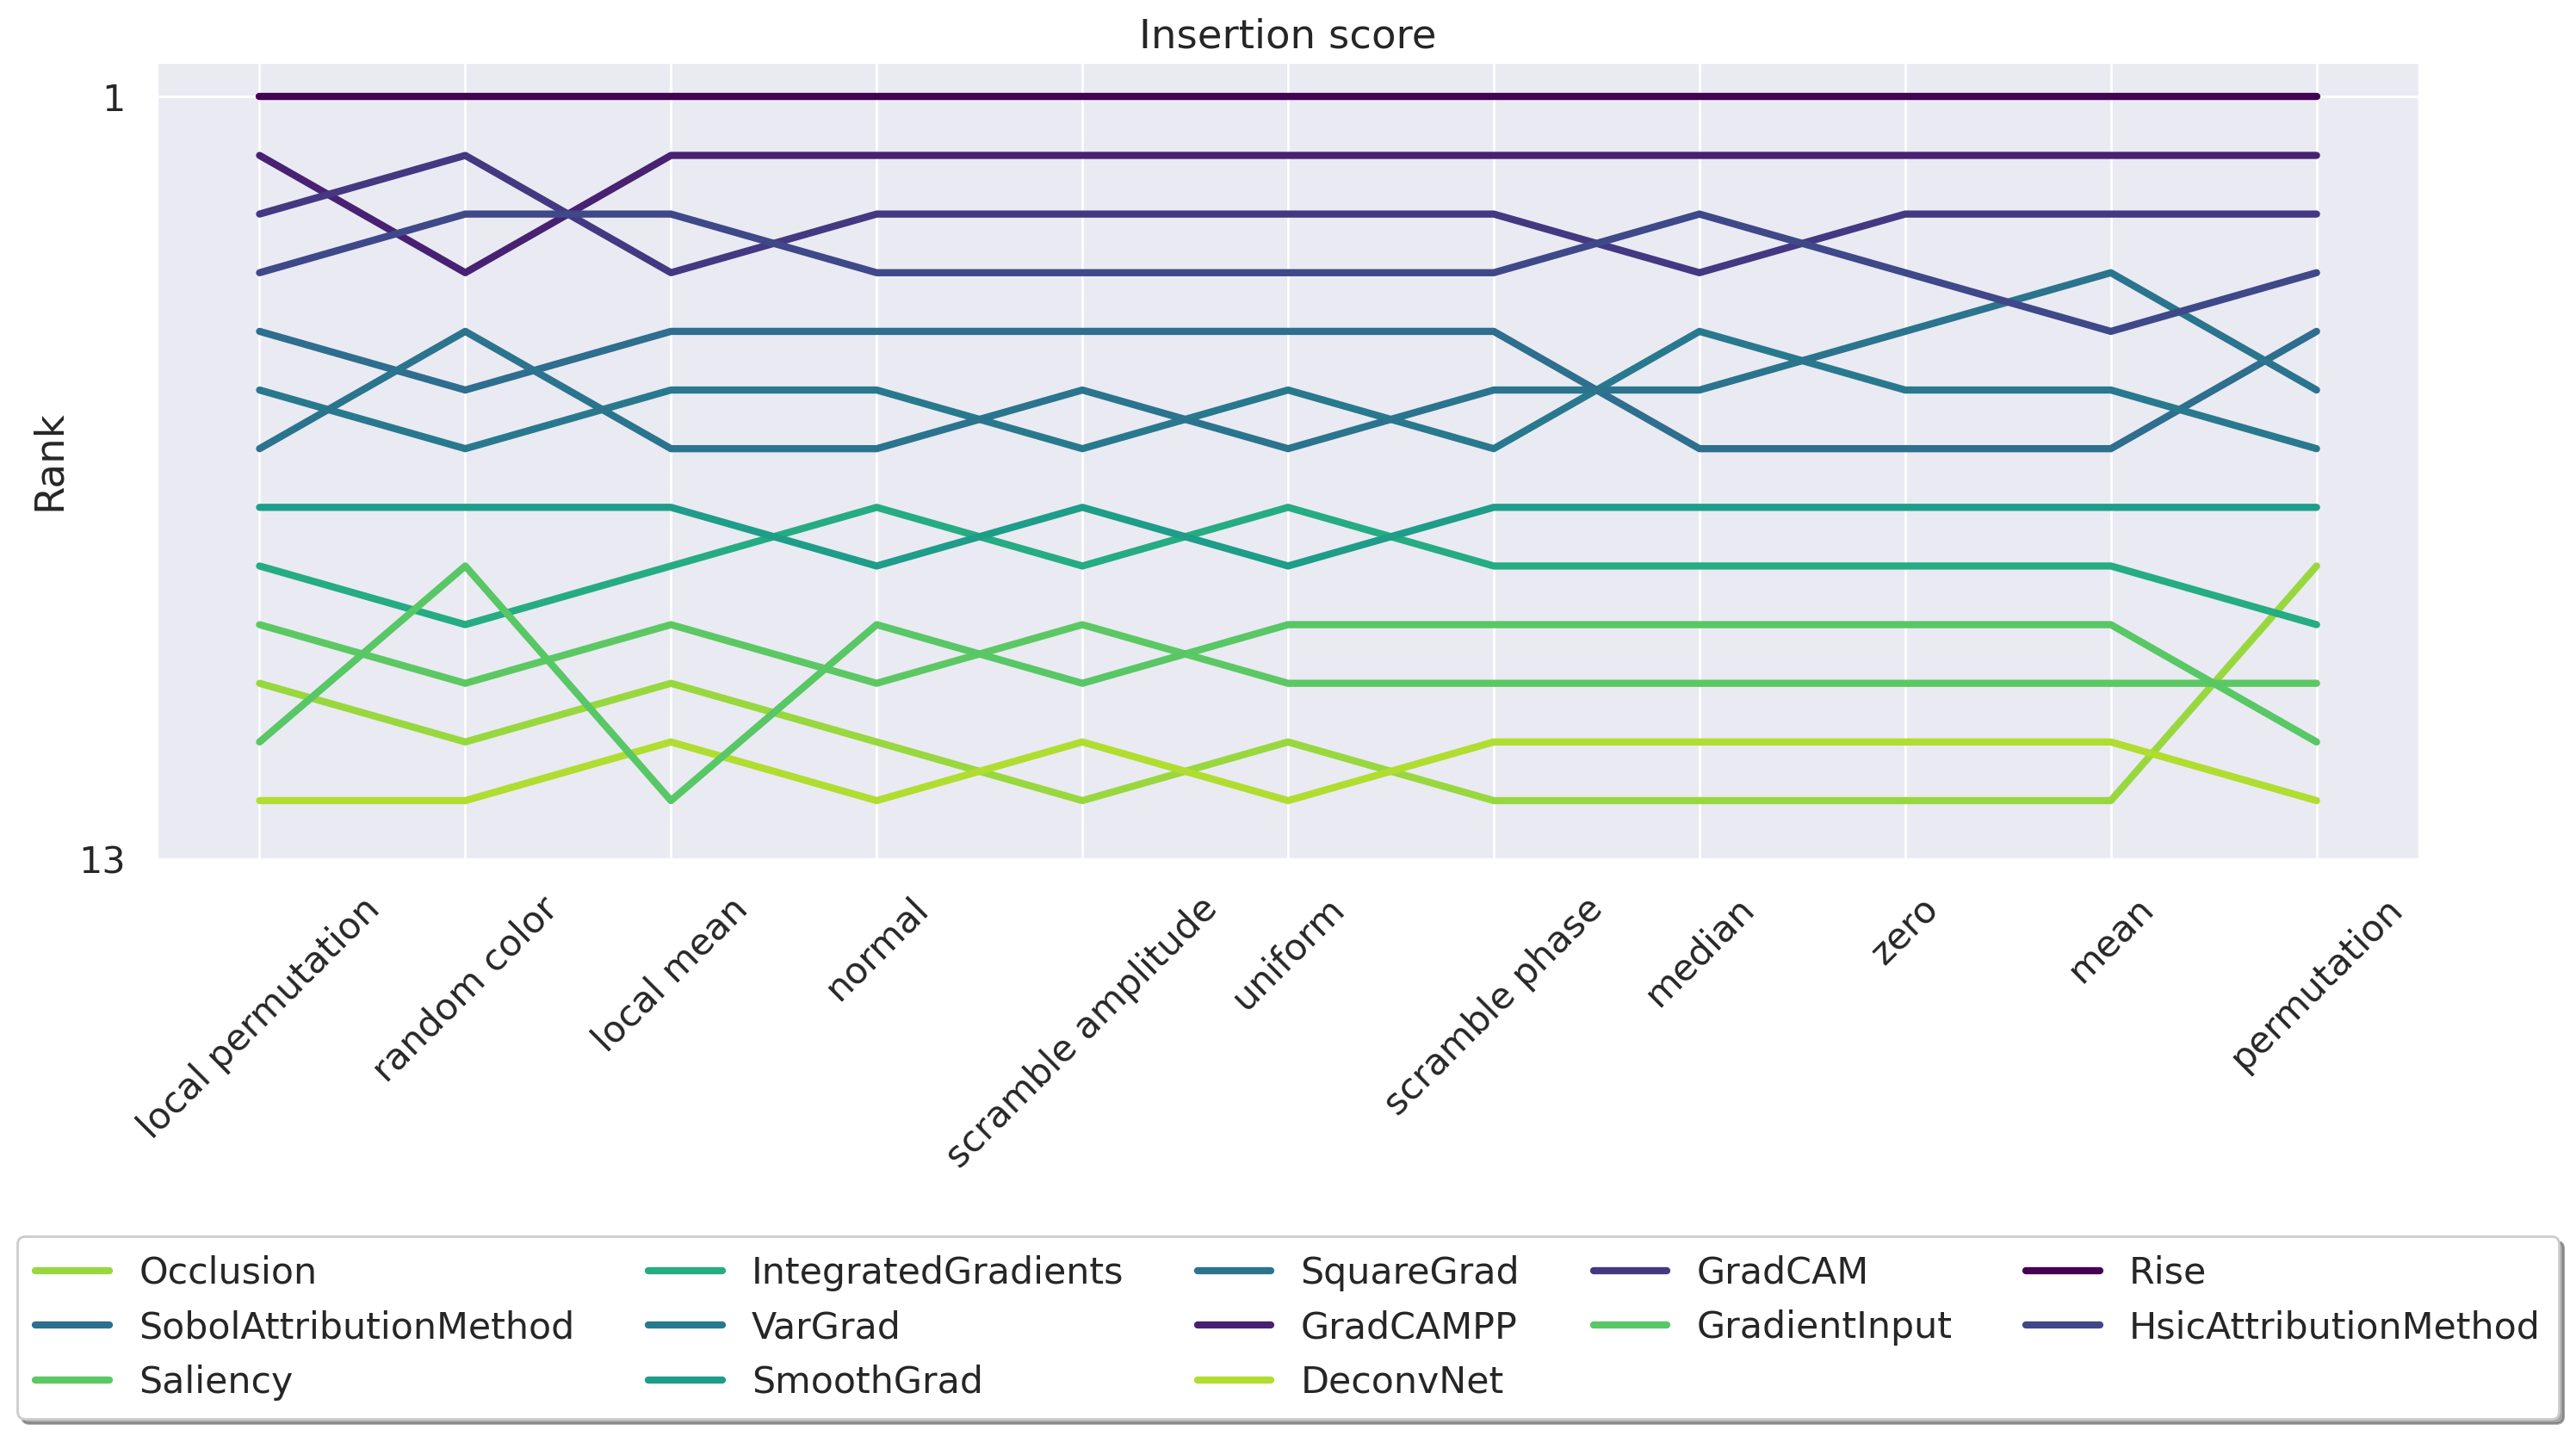

In [ ]:
sns.set(font_scale=1.4)
set_size(16, 10)
cmap = plt.get_cmap('viridis')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=5, frameon=True,
                      facecolor='white') # = ivan

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Insertion score")
plt.tight_layout()
plt.savefig('insertion_ranking.png', dpi=400, transparent=True)
plt.show()

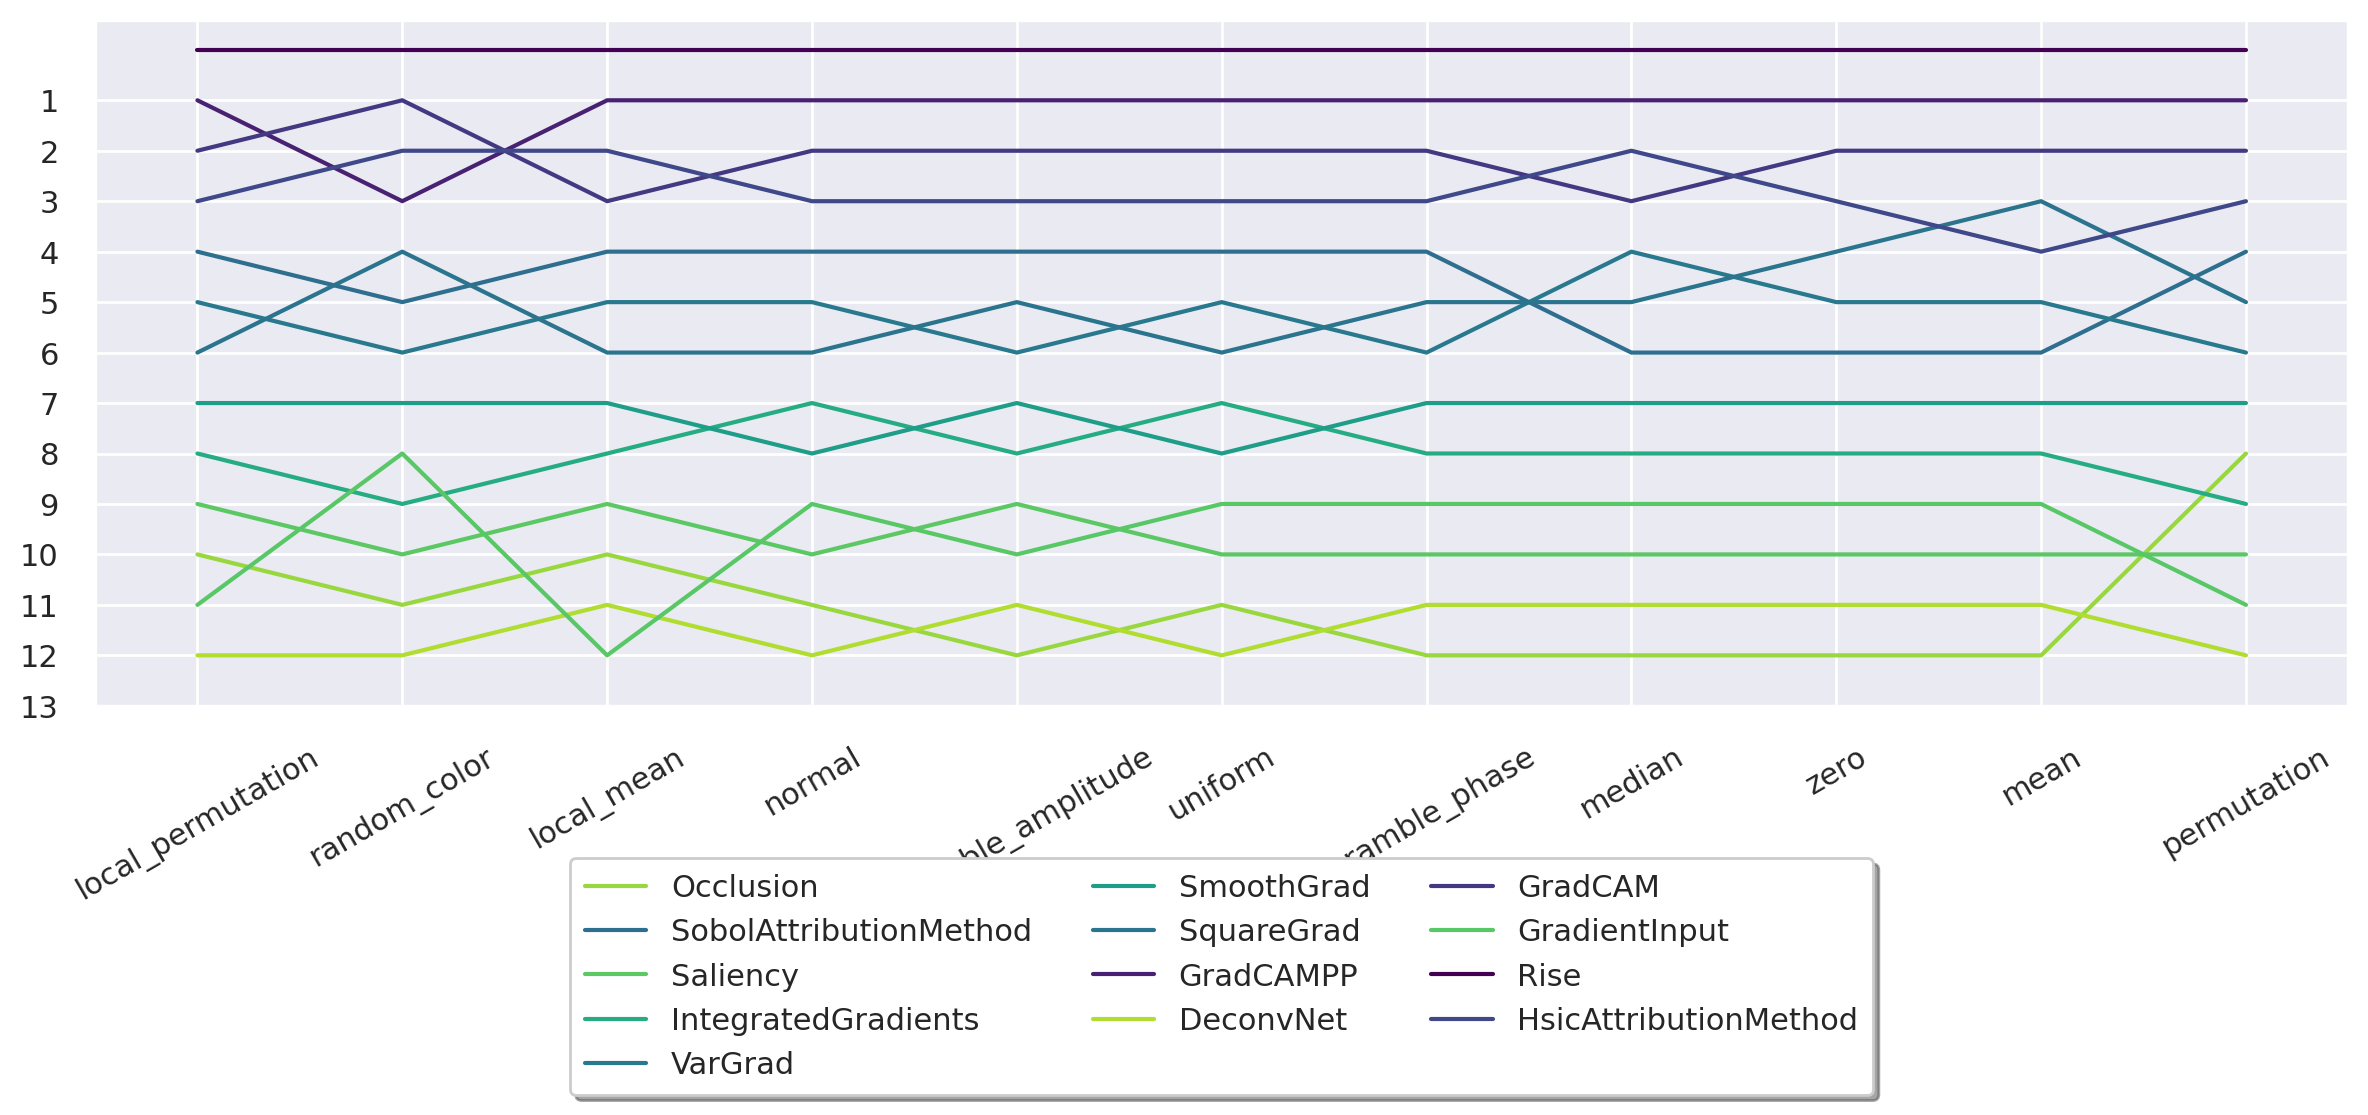

In [ ]:
sns.set(font_scale=1)
set_size(12, 6)
cmap = plt.get_cmap('viridis')


for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=3, frameon=True,
                      facecolor='white') # = ivan

plt.tight_layout()
plt.xticks(range(len(baselines)), baselines, rotation=30)
plt.yticks(range(len(methods)), [len(methods) - i for i in range(len(methods))])
plt.show()